<a href="https://colab.research.google.com/github/Anubhuti710/Denoiser/blob/main/Imputer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Install required packages
!pip install wandb torch torchvision torchaudio pandas numpy matplotlib scikit-learn xlrd
!pip install pyts  # For time series processing
!pip install diffusers  # For diffusion models

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: hiteshwaripatel408 (hiteshwaripatel408-sardar-vallabhbhai-national-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
# Load and prepare exchange_rate data
import pandas as pd
import numpy as np
from google.colab import files

# Upload the file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load data
df = pd.read_csv(filename)
data = df.values  # Convert to numpy array
print(f"Data shape: {data.shape}")
print("First 5 rows:")
print(data[:5])

Saving exchange_rate.csv to exchange_rate (1).csv
Data shape: (7588, 9)
First 5 rows:
[['1990/1/1 0:00' 0.7855 1.611 0.861698 0.634196 0.211242 0.006838
  0.525486 0.593]
 ['1990/1/2 0:00' 0.7818 1.61 0.861104 0.633513 0.211242 0.006863
  0.523972 0.594]
 ['1990/1/3 0:00' 0.7867 1.6293 0.86103 0.648508 0.211242 0.006975
  0.526316 0.5973]
 ['1990/1/4 0:00' 0.786 1.637 0.862069 0.650618 0.211242 0.006953
  0.523834 0.597]
 ['1990/1/5 0:00' 0.7849 1.653 0.861995 0.656254 0.211242 0.00694
  0.527426 0.5985]]


In [3]:
# Data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load data again to be safe
df = pd.read_csv(filename)

# Check the first few rows to identify date column
print("Original data columns:")
print(df.head())

# Assuming the first column is the date column, we'll separate it
dates = df.iloc[:, 0]  # Save dates for reference if needed
numeric_data = df.iloc[:, 1:]  # Use only numeric columns

# Convert numeric columns to float (in case there are other non-numeric columns)
numeric_data = numeric_data.apply(pd.to_numeric, errors='coerce')

# Drop any rows with NaN values that might have been created
numeric_data = numeric_data.dropna()

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Split into train and test
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)
print(f"\nProcessed data shapes:")
print(f"Train shape: {train_data.shape}, Test shape: {test_data.shape}")
print("\nSample of scaled data:")
print(train_data[:5])

Original data columns:
            date       0       1         2         3         4         5  \
0  1990/1/1 0:00  0.7855  1.6110  0.861698  0.634196  0.211242  0.006838   
1  1990/1/2 0:00  0.7818  1.6100  0.861104  0.633513  0.211242  0.006863   
2  1990/1/3 0:00  0.7867  1.6293  0.861030  0.648508  0.211242  0.006975   
3  1990/1/4 0:00  0.7860  1.6370  0.862069  0.650618  0.211242  0.006953   
4  1990/1/5 0:00  0.7849  1.6530  0.861995  0.656254  0.211242  0.006940   

          6      OT  
0  0.525486  0.5930  
1  0.523972  0.5940  
2  0.526316  0.5973  
3  0.523834  0.5970  
4  0.527426  0.5985  

Processed data shapes:
Train shape: (6070, 8), Test shape: (1518, 8)

Sample of scaled data:
[[4.88023203e-01 4.45104327e-01 5.14050349e-01 1.03674064e-01
  7.92386252e-01 8.40529649e-02 5.35109257e-03 4.08496278e-01]
 [4.82048127e-01 4.43990079e-01 5.12794381e-01 1.02846648e-01
  7.92386252e-01 8.76511226e-02 4.47004101e-04 4.10540323e-01]
 [4.89961065e-01 4.65495072e-01 5.12637913e-

In [4]:
#  Transformer Encoder Model
import torch
import torch.nn as nn

class TransformerImputer(nn.Module):
    def __init__(self, input_dim, seq_len=96, d_model=64, nhead=4, num_layers=3):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Linear(d_model, input_dim)
        self.seq_len = seq_len

    def forward(self, x, mask):
        # x: (batch, seq_len, input_dim)
        # mask: (batch, seq_len, input_dim)
        masked_x = x * (1 - mask)  # Zero out masked values
        x_embed = self.embedding(masked_x)
        x_embed = x_embed.permute(1, 0, 2)  # (seq_len, batch, d_model)
        output = self.transformer(x_embed)
        output = output.permute(1, 0, 2)  # (batch, seq_len, d_model)
        output = self.output(output)
        return output

In [7]:
#  Debugging
print("=== DEBUG MODE ===")

# 1. Force CPU and tiny data
device = torch.device("cpu")
train_data_debug = np.random.rand(100, 8)  # 100 fake samples
print(f"Debug data shape: {train_data_debug.shape}")

# 2. Minimal model test
model = TransformerImputer(input_dim=8).to(device)
test_input = torch.rand(1, 96, 8)  # (batch, seq_len, features)
test_mask = (torch.rand(1, 96, 8) > 0.9).float()  # 10% mask
print(f"Test input shape: {test_input.shape}")
print(f"Test mask sum: {test_mask.sum().item()} (should be ~77 for 10% of 768)")

# 3. Forward pass test
with torch.no_grad():
    output = model(test_input, test_mask)
    print(f"Output shape: {output.shape}")
    print("Forward pass worked!")

# 4. One training step
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

model.train()
optimizer.zero_grad()
output = model(test_input, test_mask)
loss = loss_fn(output * test_mask, test_input * test_mask)
loss.backward()
optimizer.step()

print(f"Loss after 1 step: {loss.item():.4f}")
print("=== SUCCESS ===")

=== DEBUG MODE ===
Debug data shape: (100, 8)
Test input shape: torch.Size([1, 96, 8])
Test mask sum: 72.0 (should be ~77 for 10% of 768)
Output shape: torch.Size([1, 96, 8])
Forward pass worked!


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Loss after 1 step: 0.0817
=== SUCCESS ===


In [10]:
# Complete Fixed Implementation with W&B Sweep
import wandb
import torch
import numpy as np
from torch import nn

# 1. Data Preparation (must run before sweep)
def prepare_data(data, seq_len=96):
    num_samples = len(data) - seq_len
    x = torch.FloatTensor(np.array([data[i:i+seq_len] for i in range(num_samples)]))
    return x

# Split your data first (add this before sweep)
x_full = prepare_data(train_data)  # Using your preprocessed train_data
x_train = x_full[:int(0.8*len(x_full))]  # 80% train
x_val = x_full[int(0.8*len(x_full)):]    # 20% val

# 2. Training Function with Error Handling
def train_with_sweep():
    try:
        wandb.init()  # No need for project/entity in sweep agent

        config = wandb.config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Model with sweep parameters
        model = TransformerImputer(
            input_dim=train_data.shape[1],
            d_model=config.d_model,
            nhead=config.nhead,
            num_layers=config.num_layers,
            seq_len=96
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.MSELoss()

        # Training loop
        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0

            # Shuffle batches
            indices = torch.randperm(len(x_train))

            for i in range(0, len(x_train), config.batch_size):
                batch_idx = indices[i:i+config.batch_size]
                batch = x_train[batch_idx].to(device)
                mask = (torch.rand(batch.shape) < config.mask_ratio)
                mask = mask.float().to(device)

                optimizer.zero_grad()
                output = model(batch, mask)
                loss = criterion(output * mask, batch * mask)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            # Validation
            val_loss = 0
            model.eval()
            with torch.no_grad():
                for i in range(0, len(x_val), config.batch_size):
                    val_batch = x_val[i:i+config.batch_size].to(device)
                    val_mask = (torch.rand(val_batch.shape) < config.mask_ratio).float().to(device)
                    val_loss += criterion(model(val_batch, val_mask) * val_mask, val_batch * val_mask).item()

            wandb.log({
                "epoch": epoch,
                "train_loss": epoch_loss / (len(x_train) / config.batch_size),
                "val_loss": val_loss / (len(x_val) / config.batch_size),
                "lr": optimizer.param_groups[0]['lr']
            })

    except Exception as e:
        print(f"Error in sweep: {str(e)}")
        raise

# 3. Sweep Configuration (use your existing sweep ID)
sweep_id = "rl14t3ul"  # Your existing sweep ID

# 4. Run the agent
wandb.agent(sweep_id, train_with_sweep, count=20)

wandb: Agent Starting Run: xju80vky with config:
wandb: 	batch_size: 32
wandb: 	d_model: 64
wandb: 	epochs: 50
wandb: 	lr: 0.0006008868618954467
wandb: 	mask_ratio: 0.3
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▂▂▁▂▃▃▃▄▅▇▆▆▅▆▆▆▇▇▆▇▇▇▇▇▇█▇▇▇▇▆███████
epoch,49
lr,0.0006
train_loss,0.00016
val_loss,0.01139


wandb: Agent Starting Run: xhqqhzw2 with config:
wandb: 	batch_size: 64
wandb: 	d_model: 64
wandb: 	epochs: 50
wandb: 	lr: 0.0009062175956526714
wandb: 	mask_ratio: 0.3
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▂▁▂▁▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▃▄▄▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅
epoch,49
lr,0.00091
train_loss,0.0002
val_loss,0.00947


wandb: Agent Starting Run: 4p37tzur with config:
wandb: 	batch_size: 64
wandb: 	d_model: 128
wandb: 	epochs: 50
wandb: 	lr: 8.808018738168462e-05
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▂
epoch,49
lr,9e-05
train_loss,9e-05
val_loss,0.00085


wandb: Agent Starting Run: 47vn6y0t with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00017914679151663596
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▂▂▂▁▁
epoch,49
lr,0.00018
train_loss,8e-05
val_loss,0.00052


wandb: Agent Starting Run: n8mk1uew with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0001713370188862643
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▃▂▁▂▂▁▂▁▁▂▂▁▁▂▂▁▂▁▂▂▃▃▂▂▂▃▃▃▃▃▃▃▃▃▃▃
epoch,49
lr,0.00017
train_loss,8e-05
val_loss,0.00077


wandb: Agent Starting Run: dp3s7ol5 with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0003239544870929445
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▂▁▂▂▁▁▂▂▁▂▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂
epoch,49
lr,0.00032
train_loss,7e-05
val_loss,0.00064


wandb: Agent Starting Run: 48lq1knx with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00028748504421382274
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▂▁▂▂▂▂▂▂▂▂▂▂▂▃▃▂▂▃▃▃▃
epoch,49
lr,0.00029
train_loss,8e-05
val_loss,0.00086


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6xdc6qzm with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00021059229202877408
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▂▂▃▃▃▃
epoch,49
lr,0.00021
train_loss,7e-05
val_loss,0.00132


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dz820y28 with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.000214840956185215
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▁▁▂▂▂▁▁▂▂▁▂▂▂▂▂▂▂▃▂▂
epoch,49
lr,0.00021
train_loss,8e-05
val_loss,0.00066


wandb: Agent Starting Run: l8f0ywhk with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00023121373400127263
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▂▁▂▁▂▂▂▂▃▃▃▃▄▃▄▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆
epoch,49
lr,0.00023
train_loss,7e-05
val_loss,0.0015


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zkamuzrh with config:
wandb: 	batch_size: 64
wandb: 	d_model: 128
wandb: 	epochs: 50
wandb: 	lr: 8.23801419577633e-05
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
epoch,49
lr,8e-05
train_loss,9e-05
val_loss,0.00096


wandb: Agent Starting Run: 9i49xqms with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00020831151031176336
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▂▂▁▂▁▂▁▁▁▂▂▁▂▃▂▂▂▃▂▂▂▃▃▃▃▂▃▄▃▄▃▃▄
epoch,49
lr,0.00021
train_loss,8e-05
val_loss,0.00089


wandb: Agent Starting Run: i8f60wb4 with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00025456695238669475
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▂▂▂▃▄▃▃▃▃▃▄▄▄▅▄▄▄▅▅▆▅▆▅
epoch,49
lr,0.00025
train_loss,7e-05
val_loss,0.00143


wandb: Agent Starting Run: nbtgl0fq with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00031208118695129187
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▁▂▂▃▂▂▃▂▃▂▃▃▄▃▃▃▃▃▃▄▄
epoch,49
lr,0.00031
train_loss,7e-05
val_loss,0.00099


wandb: Agent Starting Run: dvi0lejn with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0001989997661906166
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▂▂▁▂▂▁▁▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▃▃▃▃▃▂▂
epoch,49
lr,0.0002
train_loss,8e-05
val_loss,0.00071


wandb: Agent Starting Run: z09pyow7 with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.000317845398986599
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▁▁▁▂▂▁▂▁▂▂▁▂▁▁▂▂▂▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃
epoch,49
lr,0.00032
train_loss,7e-05
val_loss,0.00105


wandb: Agent Starting Run: 5xdeatnm with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0005993679744306995
wandb: 	mask_ratio: 0.2
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▂▂▃
epoch,49
lr,0.0006
train_loss,0.00012
val_loss,0.00317


wandb: Agent Starting Run: q31l2e3y with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0004279373708468858
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 2


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch,49
lr,0.00043
train_loss,7e-05
val_loss,0.00069


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1vl6iv0f with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.00023052204132007257
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 3


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▁▁▁▁▁▂▁▂▁▂▂▂▂▃▁▂▃▂▃▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
epoch,49
lr,0.00023
train_loss,8e-05
val_loss,0.00094


wandb: Agent Starting Run: 8ezfiiba with config:
wandb: 	batch_size: 64
wandb: 	d_model: 256
wandb: 	epochs: 50
wandb: 	lr: 0.0002000845952882663
wandb: 	mask_ratio: 0.1
wandb: 	nhead: 8
wandb: 	num_layers: 4


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▂▃▁▂▂▁▂▂▂▂▂▂▂▂▂▃▄▂▃▃▂▃▄▄▃▄▄▄▄▄▅▅▅
epoch,49
lr,0.0002
train_loss,8e-05
val_loss,0.00122


wandb: Sorting runs by +summary_metrics.val_loss


=== Best Run ===
Config: {'lr': 0.00017914679151663596, 'nhead': 8, 'epochs': 50, 'd_model': 256, 'batch_size': 64, 'mask_ratio': 0.1, 'num_layers': 2}
Best Val Loss: 0.0005188344085440975

=== Performance by Mask Ratio ===
Mask 10.0% | Val Loss: 0.000942
Mask 20.0% | Val Loss: 0.003172
Mask 30.0% | Val Loss: 0.010433


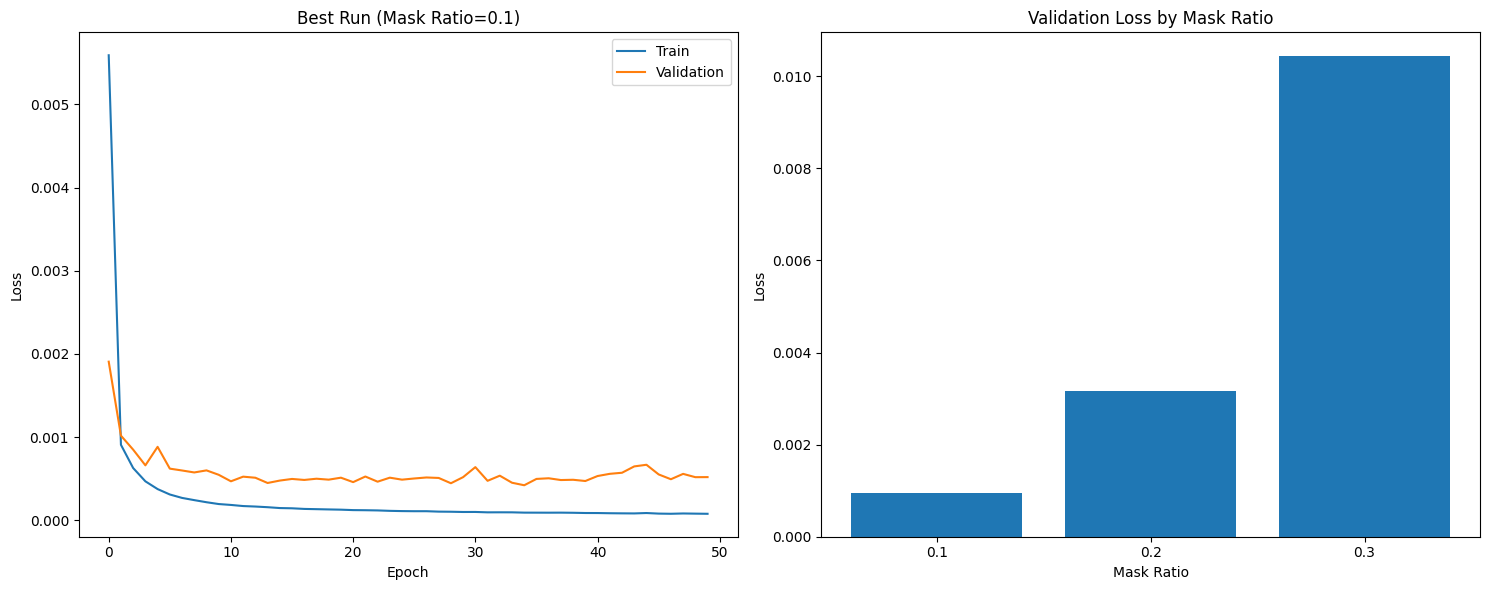

In [19]:
# Visualization Using W&B
import matplotlib.pyplot as plt
import wandb
import numpy as np

# 1. Initialize connection
api = wandb.Api()
sweep = api.sweep("hiteshwaripatel408-sardar-vallabhbhai-national-institute/time-series-transformer/sweeps/rl14t3ul")
best_run = sweep.best_run()

# 2. Get all runs grouped by mask_ratio
mask_results = {}
for run in sweep.runs:
    ratio = run.config.get('mask_ratio')
    if ratio not in mask_results:
        mask_results[ratio] = []
    mask_results[ratio].append(run.summary.get('val_loss', np.nan))

# 3. Prepare data for plotting
mask_ratios = sorted(mask_results.keys())
avg_losses = [np.nanmean(mask_results[ratio]) for ratio in mask_ratios]

# 4. Create visualization
plt.figure(figsize=(15, 6))

# Plot 1: Training Curve
plt.subplot(1, 2, 1)
history = best_run.history()
plt.plot(history['epoch'], history['train_loss'], label='Train')
plt.plot(history['epoch'], history['val_loss'], label='Validation')
plt.title(f"Best Run (Mask Ratio={best_run.config.get('mask_ratio', 'N/A')})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot 2: Mask Ratio Performance
plt.subplot(1, 2, 2)
plt.bar([str(r) for r in mask_ratios], avg_losses)
plt.title("Validation Loss by Mask Ratio")
plt.xlabel("Mask Ratio")
plt.ylabel("Loss")
plt.tight_layout()

# 5. Print results
print("=== Best Run ===")
print(f"Config: {best_run.config}")
print(f"Best Val Loss: {best_run.summary.get('val_loss', 'N/A')}\n")

print("=== Performance by Mask Ratio ===")
for ratio, loss in zip(mask_ratios, avg_losses):
    print(f"Mask {ratio*100}% | Val Loss: {loss:.6f}")

plt.show()